# Building a Predictive Model for McAfee

Our objective is to train and evaluate a predictive model that predicts whether employees click on a phishing url to visit a website or not.

## 1. Notebook Styling and Package Management

In [1]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * # Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import MinMaxScaler, LabelEncoder # Importing function for scaling the data
from sklearn.preprocessing import LabelEncoder # Importing function for processing the labels
from sklearn.ensemble import GradientBoostingClassifier # Importing GB Classifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.model_selection import RandomizedSearchCV # Importing RandomSearchCV
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting

## 2. Load Data

In [2]:
trainInput = pd.read_csv("Data/Phishing_TrainSample.csv") 
testInput = pd.read_csv("Data/Phishing_TestSample.csv")

In [3]:
trainData = trainInput.drop(columns = 'Visit')
trainLabels = LabelEncoder().fit_transform(trainInput.Visit)

testData = testInput.drop(columns = 'Visit')
testLabels = LabelEncoder().fit_transform(testInput.Visit)

## 3. Train a RandomForest Classifier

In [4]:
clf = RandomForestClassifier(random_state = 1)
clf.fit(trainData, trainLabels)

RandomForestClassifier(random_state=1)

## 4. Evaluate the Classifier Using the Training Data (Not Recommended)

We first import custom functions from a custom package called custom_functions. File custom_functions.py should be in the active directory.

In [5]:
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

#### 4.1. Confusion Matrix:

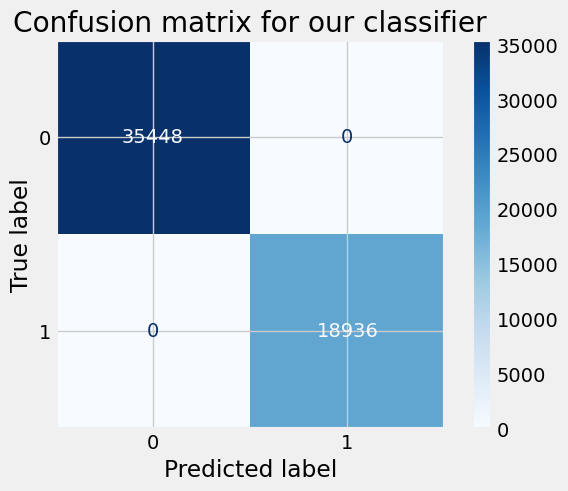

In [6]:
plot_conf_mat(clf, # The classifier object
              trainData, # The test data set aside for evaluation in train_test_split
              trainLabels # Actual labels
             )

#### 4.2. Accuracy, Precision, Recall, AUC, and F1:

In [7]:
predictedProbabilities = clf.predict_proba(trainData)
predictedLabels = clf.predict(trainData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, trainLabels)

Accuracy: 100.00
PrecisionNegative: 100.00
PrecisionPositive: 100.00
RecallNegative: 100.00
RecallPositive: 100.00
AUC Score: 100.00



In [8]:
print("F1 Score:",f1_score(trainLabels, predictedLabels, average='micro'))

F1 Score: 1.0


#### 4.3. ROC Curve:

In [9]:
positiveProbabilities = predictedProbabilities[:,1]

AUC Score = 100.000


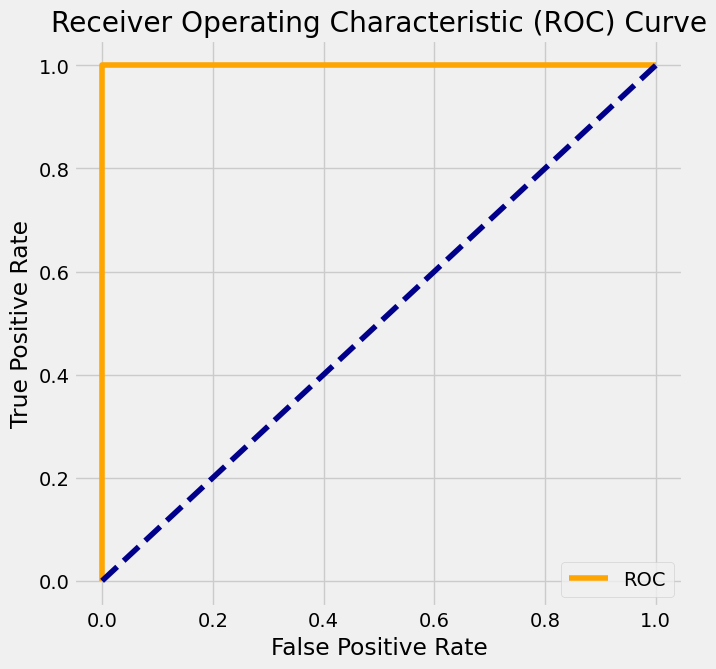

In [10]:
plot_roc_curve(trainLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

## 5. Evaluate the Classifier Using the Testing Data (Recommended)

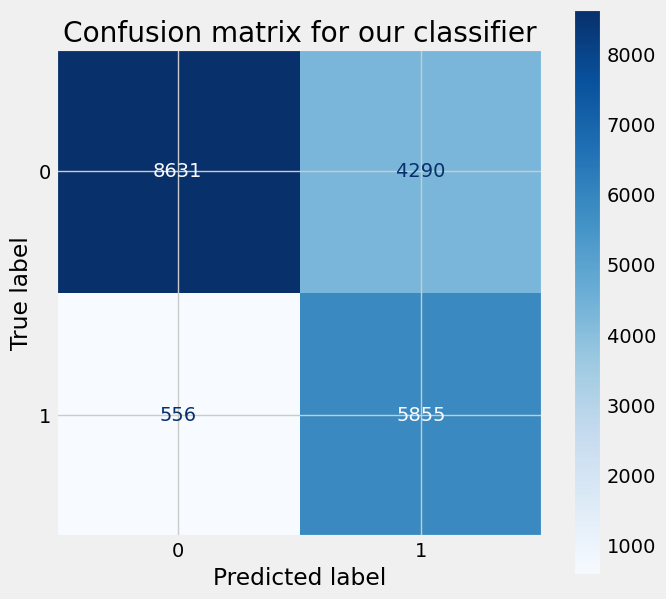

In [11]:
plot_conf_mat(clf, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [12]:
predictedProbabilities = clf.predict_proba(testData)
predictedLabels = clf.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 74.93
PrecisionNegative: 93.95
PrecisionPositive: 57.71
RecallNegative: 66.80
RecallPositive: 91.33
AUC Score: 85.31



In [13]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.7493275398303331


AUC Score = 85.314


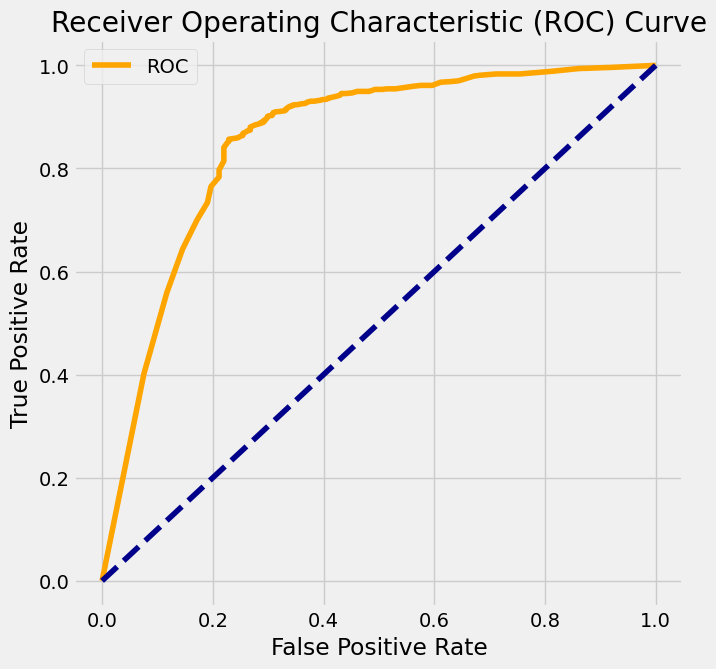

In [14]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

## 6. Train and Evaluate after Fine-tuning the Hyper-parametrs:

What are Hyper Parameters?

Hyper parameters are more like handles available to control the output or the behavior of the algorithm used for modeling. They can be supplied to algorithms as arguments. For eg: model= DecisionTreeClassifier(criterion=’entropy’), here the criterion entropy is the hyper parameter passed.

Typically, we can use one of the following two methods to fine-tune the hyperparameters in the algorithms:

* RandomSearchCV (only a few samples are randomly selected)
* GridSearchCV (considers all possible combinations of hyperparameters)

The first one, RandomSearchCV, requires the user to provide a range of values for each parameter. For instance, we select range [2,10] for max_depth in XGBoost. It also requires the user to provide the number of values (n_iter) that should be drawn for the hyperparameters. We also set n_iter to 2. That means RandomSearchCV will randomly draw two values between 2 and 9 (inclusive) and use each to build XGBoost classifiers. If max_depth is the only parameter we are tuning for, then RandomSearchCV will create 2 XGBoost classifiers. However, if we are tuning for another parameter (let's say learning_rate), then RandomSearchCV will build two models by selecting two combinations of values for max_depth and learning_rate. 

GridSearchCV, on the other hand, will build a classifier for every possible value the user provides. All possible permutations of the hyperparameters for a particular model are used to build models. The performance of each model is evaluated, and the best-performing one is selected. Since GridSearchCV uses every combination to build and evaluate the model performance, this method is highly computationally expensive. 

Given that GridSearchCV is computationally expensive, it is a good practice to start with RandomSearchCV to narrow down the range of values for each hyperparameter. Then, GridSearchCV can be used to find the best values within that range:


#### 6.1. RandomSearchCV

In [15]:
params = {
    "n_estimators" : [10,50,100,200],
    "max_depth" : np.arange(2,10,1),
    "learning_rate" : np.arange(0.1,0.9,0.1)
}

clf = XGBClassifier(objective="binary:logistic", 
                    n_jobs=16,
                    random_state = 1)

rs_model = RandomizedSearchCV(clf,
                              param_distributions=params,
                              n_iter=5, # We are asking for five models
                              scoring='roc_auc',
                              cv=5,
                              verbose=3,
                              random_state = 1)

#model fitting
rs_model.fit(trainData,trainLabels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END learning_rate=0.6, max_depth=7, n_estimators=200;, score=1.000 total time=   0.8s
[CV 2/5] END learning_rate=0.6, max_depth=7, n_estimators=200;, score=1.000 total time=   0.7s
[CV 3/5] END learning_rate=0.6, max_depth=7, n_estimators=200;, score=1.000 total time=   0.7s
[CV 4/5] END learning_rate=0.6, max_depth=7, n_estimators=200;, score=1.000 total time=   0.7s
[CV 5/5] END learning_rate=0.6, max_depth=7, n_estimators=200;, score=1.000 total time=   0.7s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=100;, score=0.909 total time=   0.2s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=100;, score=0.905 total time=   0.2s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=100;, score=0.907 total time=   0.2s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=100;, score=0.910 total time=   0.2s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=100;, score=0.909 total tim

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=16,
                                           num_parallel_tree=None,
                                           random_state=1, ...),
                   n_iter=5,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=1, scoring='roc_auc', verbose=3)

In [16]:
#parameters selected
rs_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=16,
              num_parallel_tree=None, random_state=1, ...)

Based on the output above, we see that the following values are selected as the best values for each hyperparameter:

* n_estimators: 200
* max_depth: 7 
* learning_rate: 0.6 

We can now use GridSearchCV with ranges of values around the values RandomSearchCV provided:

In [17]:
params = {
    "n_estimators" : [200],
    "max_depth" : [6,7,8],
    "learning_rate" : [0.5,0.6,0.7]
}

clf = XGBClassifier(objective="binary:logistic", 
                    n_jobs=16,
                    random_state = 1)

gs_model = GridSearchCV(clf,
                              param_grid=params,
                              scoring='roc_auc',
                              cv=2,
                              verbose=3)

#model fitting
gs_model.fit(trainData,trainLabels)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=1.000 total time=   0.5s
[CV 2/2] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=1.000 total time=   0.5s
[CV 1/2] END learning_rate=0.5, max_depth=7, n_estimators=200;, score=1.000 total time=   0.6s
[CV 2/2] END learning_rate=0.5, max_depth=7, n_estimators=200;, score=1.000 total time=   0.6s
[CV 1/2] END learning_rate=0.5, max_depth=8, n_estimators=200;, score=1.000 total time=   0.7s
[CV 2/2] END learning_rate=0.5, max_depth=8, n_estimators=200;, score=1.000 total time=   0.6s
[CV 1/2] END learning_rate=0.6, max_depth=6, n_estimators=200;, score=1.000 total time=   0.5s
[CV 2/2] END learning_rate=0.6, max_depth=6, n_estimators=200;, score=1.000 total time=   0.5s
[CV 1/2] END learning_rate=0.6, max_depth=7, n_estimators=200;, score=1.000 total time=   0.6s
[CV 2/2] END learning_rate=0.6, max_depth=7, n_estimators=200;, score=1.000 total tim

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=16, num_parallel_tree=None,
                                     random_state=1, ...),
             param_grid={'learning_rate': [0.5, 0.6, 0.7],
                         'max_depth': [6, 7, 8], 'n_estimators': [200]},
             scoring='roc_auc', verbose=3)

In [18]:
#parameters selected
gs_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=16,
              num_parallel_tree=None, random_state=1, ...)

Based on the output above, we see that the following values are selected as the best values for each hyperparameter:

* n_estimators: 200
* max_depth: 6 
* learning_rate: 0.5 

Now, we take the best estimator and evaluate it using the testing data:

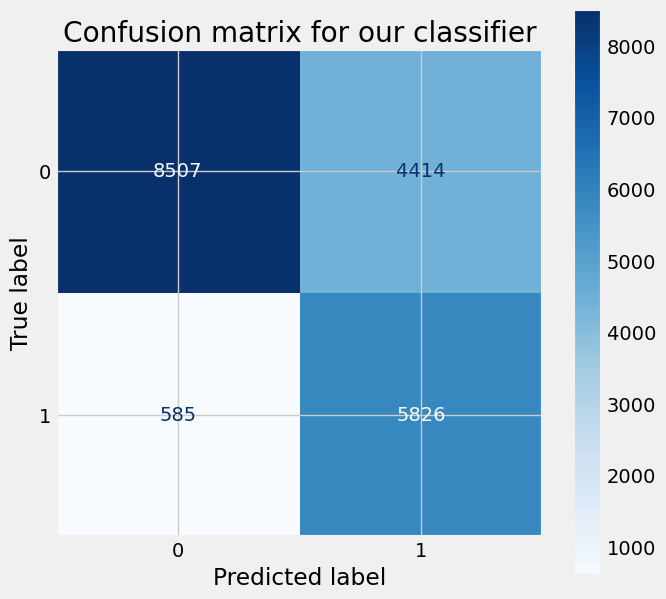

In [19]:
plot_conf_mat(gs_model.best_estimator_, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [20]:
predictedProbabilities = gs_model.best_estimator_.predict_proba(testData)
predictedLabels = gs_model.best_estimator_.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 74.14
PrecisionNegative: 93.57
PrecisionPositive: 56.89
RecallNegative: 65.84
RecallPositive: 90.88
AUC Score: 85.36



In [21]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.7414132009104075


AUC Score = 85.355


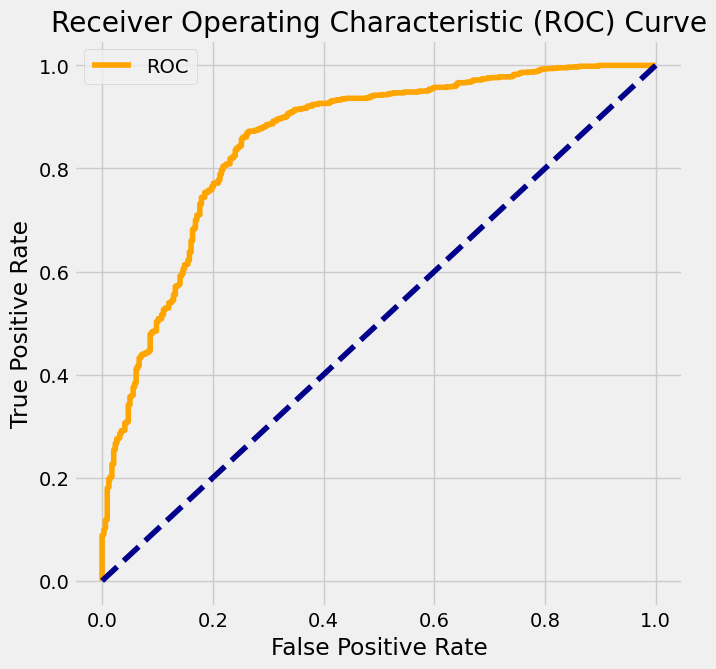

In [22]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

## 7. Balance Classes:

Occasionally, we might have a data set in which the proportion of positives to negatives is not balanced. For instance, in our data set, for every single positive case (Visit), there are three negative cases (Exist):

In [23]:
trainLabels.mean()

0.3481906443071492

Therefore, we can balance the data by giving more weight to the positive class. In a sense, misclassifying a positive case will be equal to misclassfying three negative cases:

In [24]:
# XGBoost parameter settings.
depth=6
estimators=200
lr=0.5

# fit the unweighted model
clf = XGBClassifier(objective="binary:logistic", 
                    max_depth=depth, 
                    n_estimators=estimators, 
                    learning_rate=lr, 
                    n_jobs=16,
                    scale_pos_weight=3, # Give three times more weight to the positive class (Visit)
                    random_state = 1)
clf.fit(trainData, trainLabels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=16,
              num_parallel_tree=None, random_state=1, ...)

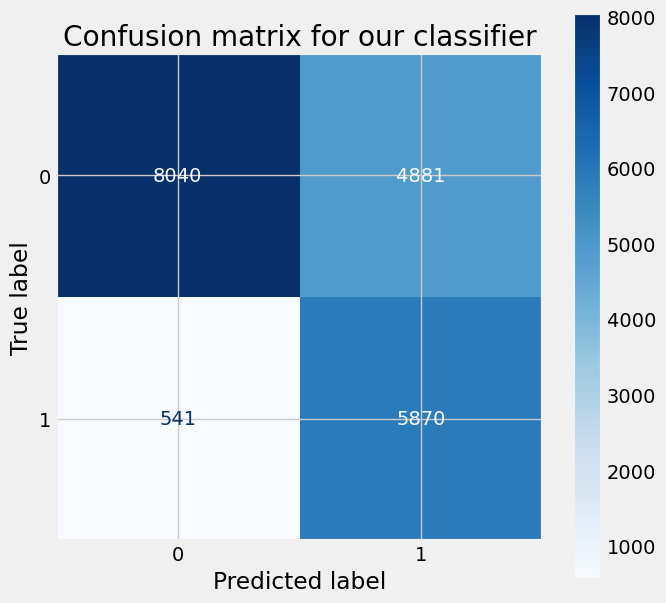

In [25]:
plot_conf_mat(clf, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [26]:
predictedProbabilities = clf.predict_proba(testData)
predictedLabels = clf.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 71.95
PrecisionNegative: 93.70
PrecisionPositive: 54.60
RecallNegative: 62.22
RecallPositive: 91.56
AUC Score: 85.14



In [27]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.7195323815435547


AUC Score = 85.142


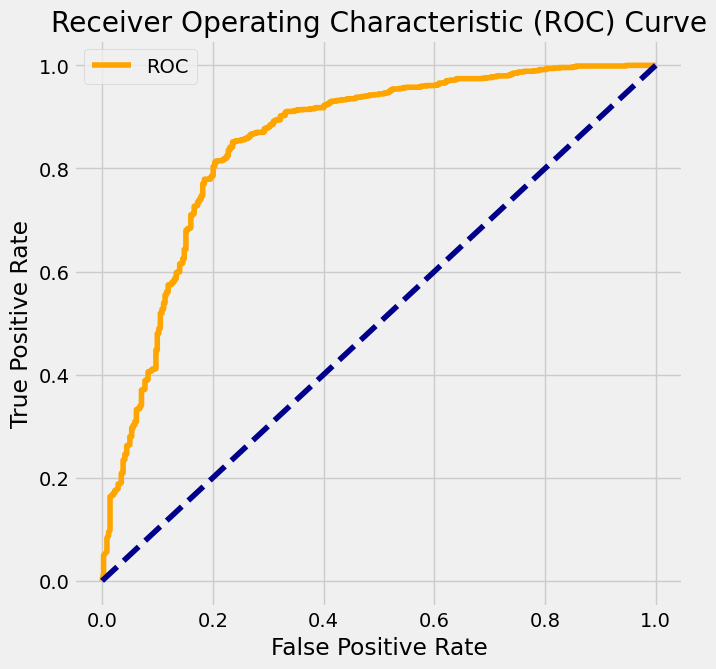

In [28]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

## 8. Apply the Model to Kaggle Data:

In [29]:
kaggleTest = pd.read_csv("Data/Phishing_KaggleTest.csv") 
kaggleTest['id'] = kaggleTest.index
kaggleTest.columns

Index(['Tool_Det_Accuracy', 'Tool_Det_Time', 'Threat_Domain', 'Threat_Type',
       'Threat_Cost', 'Dem_Gender', 'Dem_Age', 'Dem_Education',
       'Exp_Web_Reliance', 'Exp_Trust_Web', 'Exp_Past_Loss', 'Exp_Past_Enc',
       'Exp_Risk_Prop', 'Exp_Sec_Habit', 'Exp_Trust_Inst',
       'ThreatPer_Phish_Aware', 'ThreatPer_Sus', 'ThreatPer_Sev',
       'Exp_Self_Eff', 'ToolPer_Effort_Req', 'ToolPer_Cost_Det_Error',
       'ToolPer_Usefulness', 'ToolPer_Trust_Det', 'Exp_Fam_Dom',
       'Exp_Fam_Site', 'Exp_Web_Activities', 'Threat_Order', 'Tool_Warning',
       'id'],
      dtype='object')

In [30]:
kaggleTest['score'] = clf.predict_proba(kaggleTest.drop(columns = 'id'))[:,1]

In [31]:
kaggleTest[['id','score']].to_csv("Data/Kaggle_Submission.csv", index = False)

Please submit to https://www.kaggle.com/t/e7452ea8967d4abcb90fe81e68ab22c3

Each team should make at least three submissions before it is closed. 